<a href="https://colab.research.google.com/github/Aiden-Ross-Dsouza/Natural-Language-Processing/blob/main/Neural_Machine_Translation/notebooks/Seq2Seq_with_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchtext==0.6.0
import torchtext
print("torchtext version:", torchtext.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 314.5 kB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import spacy
from torch.utils.tensorboard import SummaryWriter
from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

In [ ]:
!python -m spacy download de_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 26.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
SRC_LANG = "de_core_news_sm"  # German model
TRG_LANG = "en_core_web_sm"   # English model

In [ ]:
spacy_src = spacy.load(SRC_LANG)
spacy_eng = spacy.load(TRG_LANG)

In [ ]:
## for hindi to english
import os
import torch
from torchtext.data import Field, Example, Dataset, TabularDataset, BucketIterator
import spacy

# Load Spacy tokenizer for English
spacy_en = spacy.load('en_core_web_sm')

# Define tokenization functions
def tokenize_hi(text):
    return text.split()

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

# Define the fields
SRC_FIELD = Field(tokenize=tokenize_hi, init_token='<sos>', eos_token='<eos>', lower=True)
TRG_FIELD = Field(tokenize=tokenize_en, init_token='<sos>', eos_token='<eos>', lower=True)

# Paths to the dataset files (assuming they are in the current working directory)
train_hi_path = 'train.hi'
train_en_path = 'train.en'
val_hi_path = 'val.hi'
val_en_path = 'val.en'
test_hi_path = 'test.hi'
test_en_path = 'test.en'

# Create the dataset fields
fields = [('src', SRC_FIELD), ('trg', TRG_FIELD)]

# Function to create examples
def make_examples(hi_path, en_path, fields):
    examples = []
    with open(hi_path, 'r', encoding='utf-8') as hi_file, open(en_path, 'r', encoding='utf-8') as en_file:
        for hi_line, en_line in zip(hi_file, en_file):
            src = hi_line.strip()
            trg = en_line.strip()
            examples.append(Example.fromlist([src, trg], fields))
    return examples

# Create examples for train, validation, and test datasets
train_examples = make_examples(train_hi_path, train_en_path, fields)
valid_examples = make_examples(val_hi_path, val_en_path, fields)
test_examples = make_examples(test_hi_path, test_en_path, fields)

# Initialize the datasets
train_data = Dataset(train_examples, fields)
valid_data = Dataset(valid_examples, fields)
test_data = Dataset(test_examples, fields)

# Build vocabulary
SRC_FIELD.build_vocab(train_data, min_freq=2)
TRG_FIELD.build_vocab(train_data, min_freq=2)

# Create iterators for the datasets
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=32,
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
)

# Verify the dataset
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

print(vars(train_data.examples[0]))


/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


Number of training examples: 10000
Number of validation examples: 5000
Number of testing examples: 3000
{'src': ['फुलस्क्रीन', '(_', 'f)'], 'trg': ['_', 'fullscreen']}


In [ ]:
## for german to english

import os
from torchtext.data import Field, Example, Dataset, TabularDataset, BucketIterator
import spacy

# Load Spacy tokenizers
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

# Define tokenization functions
def tokenize_de(text):
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

# Define the fields
SRC_FIELD = Field(tokenize=tokenize_de, init_token='<sos>', eos_token='<eos>', lower=True)
TRG_FIELD = Field(tokenize=tokenize_en, init_token='<sos>', eos_token='<eos>', lower=True)

# Paths to the dataset files (assuming they are in the current working directory)
train_de_path = 'train.de'
train_en_path = 'train.en'
val_de_path = 'val.de'
val_en_path = 'val.en'
test_de_path = 'test.de'
test_en_path = 'test.en'

# Create the dataset fields
fields = [('src', SRC_FIELD), ('trg', TRG_FIELD)]

# Function to create examples
def make_examples(de_path, en_path, fields):
    examples = []
    with open(de_path, 'r', encoding='utf-8') as de_file, open(en_path, 'r', encoding='utf-8') as en_file:
        for de_line, en_line in zip(de_file, en_file):
            src = de_line.strip()
            trg = en_line.strip()
            examples.append(Example.fromlist([src, trg], fields))
    return examples

# Create examples for train, validation, and test datasets
train_examples = make_examples(train_de_path, train_en_path, fields)
valid_examples = make_examples(val_de_path, val_en_path, fields)
test_examples = make_examples(test_de_path, test_en_path, fields)

# Initialize the datasets
train_data = Dataset(train_examples, fields)
valid_data = Dataset(valid_examples, fields)
test_data = Dataset(test_examples, fields)

# Build vocabulary
SRC_FIELD.build_vocab(train_data, min_freq=2)
TRG_FIELD.build_vocab(train_data, min_freq=2)

# Create iterators for the datasets
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=32,
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
)

# Verify the dataset
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

print(vars(train_data.examples[0]))


/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


Number of training examples: 29000
Number of validation examples: 1014
Number of testing examples: 1000
{'src': ['zwei', 'männer', 'betrachten', 'etwas', 'im', 'garten'], 'trg': ['two', 'young', 'guys', 'with', 'shaggy', 'hair', 'look', 'at', 'their', 'hands', 'while', 'hanging', 'out', 'in', 'the', 'yard', '.']}


In [ ]:
print("SRC vocabulary:", SRC_FIELD.vocab.itos)
print("TRG vocabulary:", TRG_FIELD.vocab.itos)

SRC vocabulary: ['<unk>', '<pad>', '<sos>', '<eos>', 'के', 'और', 'में', 'की', 'से', 'को', 'है', 'का', '"', 'कि', 'पर', 'है।', 'लिए', 'एक', 'तो', 'नहीं', 'जो', 'भी', 'ने', 'ही', 'कर', 'यह', 'वह', 'हैं', 'हो', 'किया', 'करने', 'इस', 'या', 'न', 'है,', 'अपने', 'तुम', 'तथा', 'कुछ', 'हैं।', 'उनके', 'वे', 'हम', 'है.', 'कोई', 'करते', 'किसी', 'लोग', 'जब', 'गया', 'रूप', 'लोगों', 'साथ', 'ये', 'द्वारा', 'जा', 'ख़ुदा', 'तक', 'अपनी', 'उस', 'उसके', 'दिया', 'क्या', 'अल्लाह', 'उन्हें', 'जाता', 'मैं', 'उसे', 'उन', 'करना', 'फिर', 'रहा', 'आप', 'रहे', 'समय', 'करता', 'भारत', 'हुए', 'होता', 'अधिक', 'करें', 'उनकी', 'तरह', 'बहुत', 'सकता', 'ओर', 'वाले', 'था', 'बात', 'हमने', 'पास', 'था।', 'दिन', 'तुम्हारे', 'दो', 'बाद', 'पहले', 'सभी', 'ऐसे', 'थे', 'प्रकार', 'यदि', 'हैं,', 'कहा', 'हमारे', 'हुआ', 'होने', 'दी', 'काम', 'गए', 'जाने', 'होती', '(_', 'सकते', 'उसकी', 'प्राप्त', '"और', 'कारण', 'एवं', 'अन्य', 'इन', 'है"', 'क्षेत्र', 'होते', 'उन्होंने', 'गई', 'अगर', 'कम', 'थे।', 'मुझे', 'नाम', 'किए', 'विकास', 'दोनों', 'करो',

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, dropout):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = nn.Dropout(dropout)
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, bidirectional = True)
        self.fc_hidden = nn.Linear(hidden_size*2, hidden_size) #attention
        self.fc_cell = nn.Linear(hidden_size*2, hidden_size) #attention
    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        encoder_states, (hidden, cell) = self.rnn(embedded)

        hidden = self.fc_hidden(torch.cat((hidden[0:1], hidden[1:2]), dim=2))
        cell = self.fc_cell(torch.cat((cell[0:1], cell[1:2]), dim=2))

        return encoder_states, hidden, cell

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_size, embedding_size, hidden_size, num_layers, dropout):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = nn.Dropout(dropout)
        self.output_dim = output_size
        self.embedding = nn.Embedding(output_size, embedding_size)
        self.rnn = nn.LSTM(hidden_size*2 + embedding_size, hidden_size, num_layers)
        self.energy = nn.Linear(hidden_size*3, 1) #attention
        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=0) #attention

    def forward(self, src, encoder_states, hidden, cell): #encoder_states in attention
        src = src.unsqueeze(0)
        embedded = self.dropout(self.embedding(src))
        sequence_length = encoder_states.shape[0]
        h_reshaped = hidden.repeat(sequence_length, 1, 1) #attention
        energy = self.relu(self.energy(torch.cat((h_reshaped, encoder_states), dim=2))) #attention
        attention = self.softmax(energy) #attention
        attention = attention.permute(1, 2 ,0) #attention
        encoder_states = encoder_states.permute(1, 0, 2) #attention
        context_vector = torch.bmm(attention, encoder_states).permute(1, 0, 2) #attention
        rnn_input = torch.cat((context_vector, embedded), dim = 2) #attention

        outputs, (hidden, cell) = self.rnn(rnn_input, (hidden, cell)) #without attention replace rnn_input with embedded
        predictions = self.fc(outputs.squeeze(0))
        return predictions, hidden, cell


In [ ]:
import random
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = src.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)
        encoder_states, hidden, cell = self.encoder(src)
        x = trg[0]
        for t in range(1, max_len):
            output, hidden, cell = self.decoder(x, encoder_states, hidden, cell)
            outputs[t] = output
            if random.random() < teacher_forcing_ratio:
                x = trg[t]
            else:
                x = output.argmax(1)
        return outputs


In [ ]:
num_epochs = 100
learning_rate = 3e-4
batch_size = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size_encoder = len(SRC_FIELD.vocab)
output_size = len(TRG_FIELD.vocab)
encoder_embedding_size = 300
decoder_embedding_size = 300
hidden_size = 1024
num_layers = 1

enc_dropout = 0.5
dec_dropout = 0.5

step = 0
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=batch_size,
    sort_within_batch=True,
    sort_key=lambda x: len(x.src),
    device=device
)


encoder_net = Encoder(input_size_encoder, encoder_embedding_size, hidden_size, num_layers, enc_dropout)
decoder_net = Decoder(output_size, decoder_embedding_size, hidden_size, num_layers, dec_dropout)
pad_idx = TRG_FIELD.vocab.stoi[TRG_FIELD.pad_token]
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
model = Seq2Seq(encoder_net, decoder_net, device).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

losses = []
checkpoint_path = "model_checkpoint.pth"
load = True
if os.path.exists(checkpoint_path) and load:
    print("loaded")
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    epoch = checkpoint["epoch"]
    losses = checkpoint["losses"]



loaded


In [ ]:
len(losses)

10716

In [ ]:
# Define the initial value for teacher forcing ratio
initial_teacher_forcing_ratio = 0.6
scheduled_sampling_decay = 0.01
for epoch in range(num_epochs):
    # Calculate the current teacher forcing ratio for this epoch
    teacher_forcing_ratio = initial_teacher_forcing_ratio / (1 + scheduled_sampling_decay * epoch)
    teacher_forcing_ratio = max(teacher_forcing_ratio, 0.0)  # Ensure the ratio doesn't go negative

    print(f"Epoch {epoch+1} / {num_epochs}, Teacher Forcing Ratio: {teacher_forcing_ratio:.4f}")

    checkpoint = {
        "epoch": epoch + 1,
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "losses": losses
    }
    torch.save(checkpoint, checkpoint_path)

    model.train()
    for batch_idx, batch in enumerate(test_iterator):
        src = batch.src.to(device)
        trg = batch.trg.to(device)
        optimizer.zero_grad()

        # Pass the teacher forcing ratio to the model
        output = model(src, trg, teacher_forcing_ratio=teacher_forcing_ratio)

        output_dim = output.shape[2]
        output = output[1:].reshape(-1, output_dim)
        trg = trg[1:].reshape(-1)

        loss = criterion(output, trg)
        losses.append(loss.item())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()

        if step % 10 == 0:
            print(f"Loss = {loss.item():.4f}")
        step = step + 1


Epoch 1 / 100, Teacher Forcing Ratio: 0.6000
Loss = 8.9455
Loss = 3.2131
Loss = 3.7055
Loss = 3.9469
Loss = 4.9492
Loss = 5.0206
Loss = 5.4175
Loss = 5.8230
Loss = 5.7498
Loss = 5.7650
Loss = 5.7054
Loss = 6.2748
Loss = 5.7587
Loss = 5.7090
Loss = 5.7713
Loss = 5.8167
Loss = 5.6162
Loss = 5.7898
Loss = 5.9004
Epoch 2 / 100, Teacher Forcing Ratio: 0.5941
Loss = 5.5582
Loss = 4.1818
Loss = 5.0725
Loss = 2.6310
Loss = 3.7823
Loss = 5.5258
Loss = 5.0619
Loss = 5.1322
Loss = 4.9797
Loss = 5.0685
Loss = 5.3101
Loss = 5.2592
Loss = 5.2299
Loss = 5.5228
Loss = 5.4363
Loss = 5.5960
Loss = 5.6611
Loss = 5.4143
Loss = 5.5831
Epoch 3 / 100, Teacher Forcing Ratio: 0.5882
Loss = 4.9306
Loss = 3.5945
Loss = 3.1371
Loss = 4.0877
Loss = 3.4089
Loss = 4.3040
Loss = 5.2448
Loss = 5.0508
Loss = 5.0603
Loss = 5.2575
Loss = 5.0474
Loss = 5.1597
Loss = 5.3539
Loss = 5.1716
Loss = 5.2299
Loss = 5.4743
Loss = 5.2690
Loss = 5.4589
Loss = 5.7515
Epoch 4 / 100, Teacher Forcing Ratio: 0.5825
Loss = 4.1705
Loss = 2

KeyboardInterrupt: 

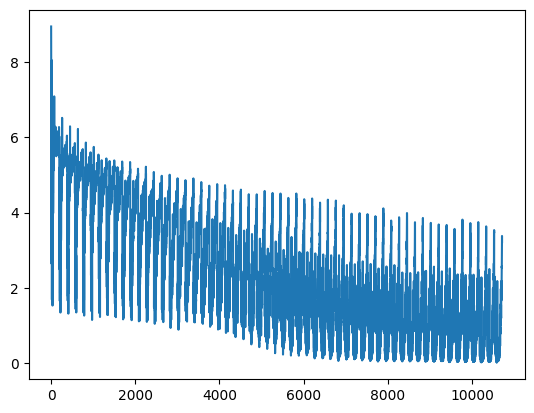

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)

In [ ]:
print(len(losses))

3187


In [ ]:
# for german to english

from torchtext.data.metrics import bleu_score
import numpy as np

def calculate_bleu(data, model, trg_field, device):
    targets = []
    outputs = []

    for example in data:
        src = example.src.to(device)
        trg = example.trg.to(device)

        output = model(src, trg, teacher_forcing_ratio=0) # No teacher forcing during testing
        output = output.argmax(dim=-1)

        # Convert token indices to tokens
        trg_tokens = [trg_field.vocab.itos[idx.item()] for idx in trg[1:].view(-1)]
        output_tokens = [trg_field.vocab.itos[idx.item()] for idx in output.squeeze(0)[1:].view(-1)]

        # Cut off <eos> token
        trg_tokens = trg_tokens[:-1]
        output_tokens = output_tokens[:-1]

        targets.append([trg_tokens])
        outputs.append(output_tokens)

    bleu = bleu_score(outputs, targets)
    return bleu

# Test the model
model.eval()
bleu_score = calculate_bleu(test_iterator, model, TRG_FIELD, device)
print(f'BLEU score: {bleu_score*100:.2f}')


BLEU score: 36.05


In [ ]:
# Function to convert tokenized examples to normal sentences
#for german to english
def convert_to_sentences(dataset, field):
    sentences = []
    for example in dataset.examples:
        tokens = getattr(example, field)
        sentence = " ".join(tokens)
        sentences.append(sentence)
    return sentences

# Convert test_data to normal German sentences
german_sentences = convert_to_sentences(test_data, 'src')
english_sentences = convert_to_sentences(test_data, 'trg')
print(english_sentences[1])

a black and white dog is running in a grassy garden surrounded by a white fence .


In [ ]:
#for german to english
def translate_sentence(model, sentence, german, english, device, max_length=50):


    # Load german tokenizer
    spacy_ger = spacy.load("de_core_news_sm")

    # Create tokens using spacy and everything in lower case (which is what our vocab is)
    if type(sentence) == str:
        tokens = [token.text.lower() for token in spacy_ger(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    # print(tokens)

    # Add <SOS> and <EOS> in beginning and end respectively
    tokens.insert(0, german.init_token)
    tokens.append(german.eos_token)

    # Go through each german token and convert to an index
    text_to_indices = [german.vocab.stoi[token] for token in tokens]

    # Convert to Tensor
    sentence_tensor = torch.LongTensor(text_to_indices).unsqueeze(1).to(device)

    # Build encoder hidden, cell state
    with torch.no_grad():
        encoder_states, hidden, cell = model.encoder(sentence_tensor)

    outputs = [english.vocab.stoi["<sos>"]]

    for _ in range(max_length):
        previous_word = torch.LongTensor([outputs[-1]]).to(device)

        with torch.no_grad():
            output, hidden, cell = model.decoder(previous_word, encoder_states, hidden, cell)
            best_guess = output.argmax(1).item()



        # Model predicts it's the end of the sentence
        if output.argmax(1).item() == english.vocab.stoi["<eos>"]:
            break

        outputs.append(best_guess)

    translated_sentence = [english.vocab.itos[idx] for idx in outputs]

    # remove start token
    return translated_sentence[1:]



i = 0;
for sentence in german_sentences:
  translated = translate_sentence(model, sentence, SRC_FIELD, TRG_FIELD, device)
  filtered_output = [word for word in translated if word not in ["[", "]", "<eos>", "'", ",", "."]]
  output_sentence = " ".join(filtered_output)
  print("German : ", sentence)
  print("English : ", english_sentences[i])
  i+=1
  print("Translated :", output_sentence)
  print()
  if(i==25):
    break



German :  der mann trägt eine orange wollmütze .
English :  the man with pierced ears is wearing glasses and an orange hat .
Translated : the man with pierced ears is wearing glasses and an orange hat

German :  ein hund läuft auf grünem rasen vor einem weißen zaun .
English :  a black and white dog is running in a grassy garden surrounded by a white fence .
Translated : a black and white dog is running in a grassy garden surrounded by a white fence

German :  ein mann und eine frau machen tae kwon do.
English :  a young female student performing a downward kick to break a board held by her karate instructor .
Translated : a young female student a downward kick kick to break a board held by a karate instructor

German :  die männer mit den helmen und schutzbrillen stehen beisammen im schnee vor den scheekettenfahrzeugen .
English :  five snowmobile riders all wearing helmets and goggles line up in a snowy clearing in a forest in front of their snowmobiles ; they are all wearing black s

In [ ]:
print("Random test")
random_sen = "ein mann und eine frau machen tae kwon do."
print("German :", random_sen)
print("English : A young female student is wearing orange glasses.")
print("Translated :"," ".join(translate_sentence(model, random_sen, SRC_FIELD, TRG_FIELD, device)))

Random test
German : ein mann und eine frau machen tae kwon do.
English : A young female student is wearing orange glasses.
Translated : a young female student a downward kick kick to break a board held by a karate instructor .


In [ ]:
# Function to convert tokenized examples to normal sentences
# for hindi to english
def convert_to_sentences(dataset, field):
    sentences = []
    for example in dataset.examples:
        tokens = getattr(example, field)
        sentence = " ".join(tokens)
        sentences.append(sentence)
    return sentences

# Assuming 'test_data' is already defined and contains the test dataset
hindi_sentences = convert_to_sentences(test_data, 'src')
english_sentences = convert_to_sentences(test_data, 'trg')

# Print an example sentence from both Hindi and English lists
print("Example Hindi Sentence:", hindi_sentences[1])
print("Example English Sentence:", english_sentences[1])


Example Hindi Sentence: (ऐ रसूल) मुझे और उस शख़्श को छोड़ दो जिसे मैने अकेला पैदा किया
Example English Sentence: " leave me ( to deal ) with him whom i created lonely , "


In [ ]:
#for hindi to english

def translate_sentence(model, sentence, src_field, trg_field, device, max_length=50):
    # Load English tokenizer
    spacy_en = spacy.load("en_core_web_sm")

    # Tokenize Hindi sentence
    if type(sentence) == str:
        tokens = sentence.lower().split()
    else:
        tokens = [token.lower() for token in sentence]

    # Add <sos> and <eos> tokens
    tokens.insert(0, src_field.init_token)
    tokens.append(src_field.eos_token)

    # Convert tokens to indices
    text_to_indices = [src_field.vocab.stoi[token] for token in tokens]

    # Convert to Tensor
    sentence_tensor = torch.LongTensor(text_to_indices).unsqueeze(1).to(device)

    # Build encoder hidden, cell state
    with torch.no_grad():
        encoder_states, hidden, cell = model.encoder(sentence_tensor)

    outputs = [trg_field.vocab.stoi[trg_field.init_token]]

    for _ in range(max_length):
        previous_word = torch.LongTensor([outputs[-1]]).to(device)

        with torch.no_grad():
            output, hidden, cell = model.decoder(previous_word, encoder_states, hidden, cell)
            best_guess = output.argmax(1).item()

        # Model predicts it's the end of the sentence
        if best_guess == trg_field.vocab.stoi[trg_field.eos_token]:
            break

        outputs.append(best_guess)

    translated_sentence = [trg_field.vocab.itos[idx] for idx in outputs]

    # remove start token
    return translated_sentence[1:]

# Assuming 'hindi_sentences' and 'english_sentences' are available
i = 0
for sentence in hindi_sentences:
    translated = translate_sentence(model, sentence, SRC_FIELD, TRG_FIELD, device)
    filtered_output = [word for word in translated if word not in ["[", "]", "<eos>", "'", ",", "."]]
    output_sentence = " ".join(filtered_output)
    print("Hindi : ", sentence)
    print("English : ", english_sentences[i])
    i += 1
    print("Translated :", output_sentence)
    print()
    if i == 25:
        break


/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


Hindi :  प्रदाय विकल्प
English :  delivery options
Translated : delivery options

Hindi :  (ऐ रसूल) मुझे और उस शख़्श को छोड़ दो जिसे मैने अकेला पैदा किया
English :  " leave me ( to deal ) with him whom i created lonely , "
Translated : " leave me to deal the to deal to whom created ?

Hindi :  (और) ऐ हमारे पालने वाले मक्के वालों में उन्हीं में से एक रसूल को भेज जो उनको तेरी आयतें पढ़कर सुनाए और आसमानी किताब और अक्ल की बातें सिखाए और उन (के नुफ़ूस) के पाकीज़ा कर दें बेशक तू ही ग़ालिब और साहिबे तदबीर है
English :  " " " our lord ! send amongst them a messenger of their own ( and indeed allah answered their invocation by sending muhammad peace be upon him ) , who shall recite unto them your verses and instruct them in the book ( this quran ) and al - hikmah ( full knowledge of the islamic laws and jurisprudence or wisdom or prophethood , etc . ) , and sanctify them . verily ! you are the all - mighty , the all - wise . " " "
Translated : " it our lord and indeed amongst amongst their thei